SYSEN 5888 Spring 2026

Jonathan Lloyd

Homework 2, Question 1


Goal: Building a convolutional neural network (ConvNet) to classify images of fruits and vegetables into their respective classes

Tools: Numpy, PyTorch, Torchvision

Data: Fruits-360 on Kaggle https://www.kaggle.com/moltean/fruits

Task: Load dataset, scale 100x100 images to 75x75, normalization and data augmentation, define training and testing datasets (85%/15% split), batch each dataset into sizes 1000, shuffle seed 42, define sequential ConvNet

In [1]:
# Check Colab Server details if running outside of Colab Online UI
'''
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout if result.returncode == 0 else "No GPU detected (CPU runtime)")
'''

'\nimport subprocess\nresult = subprocess.run([\'nvidia-smi\'], capture_output=True, text=True)\nprint(result.stdout if result.returncode == 0 else "No GPU detected (CPU runtime)")\n'

In [2]:
from google.colab import userdata

## IMPORT API KEY - UNCOMMENT APPLICABLE LINES WHEN RUNNING DIFFERENT KERNELS
# Import KAGGLE_API_KEY from .env
# KAGGLE_API_TOKEN = os.getenv("KAGGLE_API_KEY")
# Define directly - delete key before uploading to GitHub
# KAGGLE_API_TOKEN =
# When running in Colab - define in web using Colab Secrets
KAGGLE_API_TOKEN = userdata.get("KAGGLE_API_KEY")

In [3]:
# update any packages in Colab server
# %pip install --upgrade numpy pandas kagglehub torch torchvision IPython

In [4]:
# Import necessary libraries
from pathlib import Path
from dotenv import load_dotenv
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from IPython.display import display, Image

# Import dataset from Kaggle
# Kagglehub reads KAGGLE_API_TOKEN from environment (set in cell above)
os.environ["KAGGLE_API_TOKEN"] = KAGGLE_API_TOKEN
# Running locally:
# path = kagglehub.dataset_download("moltean/fruits", output_dir="/content/fruits-360")
# On Colab: use /content to avoid cache disk limits; locally omit output_dir to use cache
path = kagglehub.dataset_download("moltean/fruits")

# Locate Training and Test subfolders (Fruits-360 dataset structure)
path = Path(path)
# Kaggle zip may nest Training/Test inside a subfolder (e.g. fruits-360/Training)
# Search recursively for Training directory
train_path = None
for p in path.rglob("Training"):
    if p.is_dir() and (p.parent / "Test").exists():
        train_path = p
        break
if train_path is not None:
    test_path = train_path.parent / "Test"
else:
    # Fallback: check direct children
    if (path / "Training").exists():
        train_path, test_path = path / "Training", path / "Test"
    else:
        raise FileNotFoundError(
            f"Could not find Training/Test folders. Dataset root: {path}\n"
            f"Contents: {[d.name for d in path.iterdir()] if path.exists() else 'path does not exist'}"
        )

# Load image datasets with placeholder transform (will add scaling/normalization in next steps)
print("Loading datasets")
train_dataset = torchvision.datasets.ImageFolder(str(train_path), transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder(str(test_path), transform=transforms.ToTensor())

print(f"Dataset downloaded to: {path}")
print(f"Training samples: {len(train_dataset)} | Classes: {len(train_dataset.classes)}")
print(f"Test samples: {len(test_dataset)}")


Using Colab cache for faster access to the 'fruits' dataset.
Loading datasets
Dataset downloaded to: /kaggle/input/fruits
Training samples: 131030 | Classes: 251
Test samples: 43670


In [5]:
## Image Preprocessing

# 1. Image scaling (100x100 -> 75x75):
image_size = 75

# 2. Image normalization values for RGB to [-1, 1]
normalize_means = [0.5, 0.5, 0.5]
normalize_stds = [0.5, 0.5, 0.5]

# 3. Data augmentation and normalization for training; only normalization for validation/test
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_means, std=normalize_stds)
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_means, std=normalize_stds)
])

# Replace raw datasets with transformed datasets
train_dataset = torchvision.datasets.ImageFolder(str(train_path), transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(str(test_path), transform=test_transform)

# 4. Define training and validation split (85%/15% from train_dataset)
total_train = len(train_dataset)
val_size = int(0.15 * total_train)
train_size = total_train - val_size

SHUFFLE_SEED = 42
torch.manual_seed(SHUFFLE_SEED)  # set random seed for reproducibility
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SHUFFLE_SEED))

# 5. Define dataloaders with batch size 1000 and consistent shuffle with seed
batch_size = 1000

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(SHUFFLE_SEED))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Loading success")

Loading success


Architecture - MODEL 1:

Define a Sequential model, wherein the layers are stacked sequentially and each layer has exactly one input tensor and one output tensor. Please build a ConvNet by adding the layers to the Sequential model using the configuration below. For each of the layers, initialize the kernel weights from a Glorot uniform distribution and set the random seed to 99. Additionally, initialize the bias vector as a zero vector. In this architecture, you may use different dropout values [0.1, 0.3, 0.5] and report the impact of dropout values on model performance.
![alt text](<model 1 arch.png>)


In [6]:
# Model 1: per architecture table (2 conv layers, BatchNorm, Dropout [0.1, 0.3, 0.5], Dense 256 -> 251).
# Assumes input size 75x75; Glorot uniform, zero bias, seed 99.
NUM_CLASSES = 251

class Model1(nn.Module):
    # Sequential ConvNet: Conv2D(64)->ReLU->MaxPool, Conv2D(128)->ReLU->BN->Dropout->MaxPool, Flatten->Dense(256)->ReLU->Dense(251).
    # NOTE: forward() returns raw logits (no softmax). This is the recommended PyTorch pattern when
    # using nn.CrossEntropyLoss, which internally applies log-softmax. Apply torch.softmax(logits, dim=1)
    # at inference time only if you need class probabilities.
    def __init__(self, num_classes=251, dropout=0.1, in_channels=3, input_h=75, input_w=75):
        super(Model1, self).__init__()
        # Layer 1–2: Conv2D 64, (3,3), no padding, ReLU; MaxPool2D (2,2)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        # Layer 3–6: Conv2D 128, (3,3), no padding, ReLU; BatchNorm; Dropout; MaxPool2D (2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128, eps=0.001, momentum=0.01)  # 0.01 in PyTorch = 0.99 in Keras (weight on running stats)
        self.drop2 = nn.Dropout2d(p=dropout)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Layer 7–9: Flatten; Dense 256 ReLU; Dense 251
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_h, input_w)
            dummy = self.pool2(self.drop2(self.bn2(self.relu2(self.conv2(self.pool1(self.relu1(self.conv1(dummy))))))))
            flat_size = self.flatten(dummy).shape[1]
        self.fc1 = nn.Linear(flat_size, 256)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.relu2(self.conv2(x))
        x = self.bn2(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

    def _init_weights_biases(self):
        torch.manual_seed(99)
        for m in [self.conv1, self.conv2, self.fc1, self.fc2]:
            if hasattr(m, "weight") and m.weight is not None:
                nn.init.xavier_uniform_(m.weight)
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.zeros_(m.bias)


Architecture - MODEL 2:

The performance of the CNN model is notably impacted by the number of convolutional layers it employs. In the preceding design, two convolutional layers were integrated. Kindly introduce an additional convolutional layer (as depicted in the updated architecture below) and elaborate on the roles of convolutional layers.
![alt text](<model 2 arch.png>)

In [7]:
# Model 2: per architecture table (3 conv layers 64->128->256, BatchNorm, Dropout 0.3, Dense 512->251).
class Model2(nn.Module):
    # Sequential ConvNet per table: Conv(64)->ReLU->Pool, Conv(128)->ReLU->Pool, Conv(256)->ReLU->BN->Dropout(0.3)->Pool, Flatten->Dense(512)->ReLU->Dense(251).
    # NOTE: forward() returns raw logits (no softmax). Use nn.CrossEntropyLoss during training; apply
    # torch.softmax(logits, dim=1) at inference time only when probabilities are needed.
    def __init__(self, num_classes=251, dropout=0.3, in_channels=3, input_h=75, input_w=75):
        super(Model2, self).__init__()
        # Layers 1–2: Conv2D 64, (3,3), no padding, ReLU; MaxPool2D (2,2)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        # Layers 3–4: Conv2D 128, (3,3), no padding, ReLU; MaxPool2D (2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        # Layers 5–8: Conv2D 256, (3,3), no padding, ReLU; BatchNorm; Dropout 0.3; MaxPool2D (2,2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(256, eps=0.001, momentum=0.01)  # 0.01 in PyTorch = 0.99 in Keras (weight on running stats)
        self.drop3 = nn.Dropout2d(p=dropout)
        self.pool3 = nn.MaxPool2d(2, 2)
        # Layers 9–11: Flatten; Dense 512 ReLU; Dense 251
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_h, input_w)
            dummy = self.pool1(self.relu1(self.conv1(dummy)))
            dummy = self.pool2(self.relu2(self.conv2(dummy)))
            dummy = self.pool3(self.drop3(self.bn3(self.relu3(self.conv3(dummy)))))
            flat_size = self.flatten(dummy).shape[1]
        self.fc1 = nn.Linear(flat_size, 512)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.bn3(x)
        x = self.drop3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

    def _init_weights_biases(self):
        torch.manual_seed(99)
        for m in [self.conv1, self.conv2, self.conv3, self.fc1, self.fc2]:
            if hasattr(m, "weight") and m.weight is not None:
                nn.init.xavier_uniform_(m.weight)
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.zeros_(m.bias)


Training: The model is compiled by specifying the optimizer, the loss function and metrics to be recorded at each step of the training process. The ADAM optimizer should minimize the categorical cross entropy. The ConvNet model can be trained and evaluated with the previously created data generators. The training step size can be calculated by dividing the number of images in the generator with the batch size for training and testing data, respectively.

In [8]:
# Define data storage
results_dataframe = pd.DataFrame(columns=[
    'Model Name', 'Dropout', 'Epochs', 'Training Accuracy (%)',
    'Validation Accuracy (%)', 'Test Accuracy (%)', 'Final Test Loss'
])

# Maximum epochs to run training
# Start with 50, go down to 20 if too time consuming
MAX_EPOCHS = 50

## Helper Functions

# BASIC TRAIN
def train(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Parameters:
        model (nn.Module): The neural network model.
        loader (DataLoader): DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device: Device to run the training on.

    Returns:
        epoch_loss (float): Average loss for the epoch.
        epoch_acc (float): Accuracy for the epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# BASIC EVAL
def evaluate(model, loader, criterion, device):
    # Compute 3 accuracy percentages
    """
    Evaluate the model on validation or test data.

    Parameters:
        model (nn.Module): The neural network model.
        loader (DataLoader): DataLoader for validation/test data.
        criterion: Loss function.
        device: Device to run the evaluation on.

    Returns:
        epoch_loss (float): Average loss for the epoch.
        epoch_acc (float): Accuracy for the epoch.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# PLOT LOSS CURVES
def plot_loss(curve, dropout, dataset):
    # Plot and save loss curve
    # dataset = [Training, Validation]
    output_dir = "Plot JPGs"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.figure()
    plt.plot(curve)
    plt.xlabel("Epoch")
    if dataset == 'Training':
        plt.ylabel("Training Loss")
    elif dataset == 'Validation':
        plt.ylabel("Validation Loss")

    plt.title(f"Categorical Cross Entropy Loss Curve for {dataset} Dataset, Dropout {dropout}")
    filename = f"{output_dir}/LossCurve_{dataset}_Dataset_{dropout}_Dropout.jpg"

    plt.savefig(filename)
    plt.close()

In [9]:
# MODEL TRAIN
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50):
    """
    Train the model and evaluate on test data after each epoch.

    Parameters:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device: Device to run the training on.
        num_epochs (int): Number of training epochs.

    Returns:
        Training and validation loss and accuracy.
    """
    training_loss_curve = []
    validation_loss_curve = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        training_loss_curve.append(train_loss)
        training_accuracy.append(train_acc)
        validation_loss_curve.append(val_loss)
        validation_accuracy.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    return training_loss_curve, validation_loss_curve, training_accuracy, validation_accuracy

In [10]:
# MAIN EXPERIMENT HELPER
def run_experiment(model_arch, train_loader, val_loader, test_loader, max_epochs=50, dropout=None):
    # Run full experiment: instantiate model, train, evaluate accuracies, plot, return results to dataframe

    # Detect Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if model_arch == 1:
        model = Model1(dropout=dropout)
    elif model_arch == 2:
        model = Model2() # dropout = 0.3 by default
    else:
        raise ValueError(f"ERROR: Model selected {model_arch} does not match possible options (1, 2).")

    # Move model to device
    model.to(device)

    # Define Optimizer
    # Adam, Categorical Cross Entropy
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Train
    training_loss_curve, validation_loss_curve, training_accuracy, validation_accuracy = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, max_epochs
    )

    # Evaluate final test
    final_test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Save plots
    plot_loss(training_loss_curve, dropout, "Training")
    plot_loss(validation_loss_curve, dropout, "Validation")

    # return results
    row = {
        'Model Name': f"Model {model_arch}",
        'Dropout': dropout,
        'Epochs': max_epochs,
        'Training Accuracy (%)': training_accuracy[-1] * 100.0,
        'Validation Accuracy (%)': validation_accuracy[-1] * 100.0,
        'Test Accuracy (%)': test_acc * 100.0,
        'Final Test Loss': final_test_loss
    }

    return row

In [11]:
# Train and Test Model 1a, 1b, 1c
# For loop to pass different dropouts
DROPOUT_SELECTOR = [0.1, 0.3, 0.5]
for d in DROPOUT_SELECTOR:
    print(f"RUNNING MODEL 1, DROPOUT {d}")
    model_run = run_experiment(1, train_loader, val_loader, test_loader, max_epochs=MAX_EPOCHS, dropout=d)
    results_dataframe = pd.concat([results_dataframe, pd.DataFrame([model_run])], ignore_index=True)
    print(f"COMPLETED MODEL 1, DROPOUT {d}")

# Train and Test Model 2, no dropout arg
print(f"RUNNING MODEL 2")
model_run_2 = run_experiment(2, train_loader, val_loader, test_loader, max_epochs=MAX_EPOCHS)
results_dataframe = pd.concat([results_dataframe, pd.DataFrame([model_run_2])], ignore_index=True)
print(f"COMPLETED MODEL 2")

RUNNING MODEL 1, DROPOUT 0.1
Using device: cuda
Epoch 1/50 | Train Loss: 0.9534 | Train Acc: 0.7869 | Val Loss: 3.0911 | Val Acc: 0.2239
Epoch 2/50 | Train Loss: 0.0475 | Train Acc: 0.9860 | Val Loss: 0.7827 | Val Acc: 0.9413
Epoch 3/50 | Train Loss: 0.0239 | Train Acc: 0.9927 | Val Loss: 0.1779 | Val Acc: 0.9858
Epoch 4/50 | Train Loss: 0.0262 | Train Acc: 0.9925 | Val Loss: 0.0521 | Val Acc: 0.9900
Epoch 5/50 | Train Loss: 0.0142 | Train Acc: 0.9953 | Val Loss: 0.0371 | Val Acc: 0.9876
Epoch 6/50 | Train Loss: 0.0153 | Train Acc: 0.9953 | Val Loss: 0.0133 | Val Acc: 0.9961
Epoch 7/50 | Train Loss: 0.0138 | Train Acc: 0.9961 | Val Loss: 0.0287 | Val Acc: 0.9921
Epoch 8/50 | Train Loss: 0.0251 | Train Acc: 0.9920 | Val Loss: 0.0348 | Val Acc: 0.9885
Epoch 9/50 | Train Loss: 0.0250 | Train Acc: 0.9924 | Val Loss: 0.0511 | Val Acc: 0.9817
Epoch 10/50 | Train Loss: 0.0163 | Train Acc: 0.9944 | Val Loss: 0.0170 | Val Acc: 0.9936
Epoch 11/50 | Train Loss: 0.0121 | Train Acc: 0.9957 | Val Lo

/tmp/ipython-input-12667/3461704179.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_dataframe = pd.concat([results_dataframe, pd.DataFrame([model_run])], ignore_index=True)


COMPLETED MODEL 1, DROPOUT 0.1
RUNNING MODEL 1, DROPOUT 0.3
Using device: cuda
Epoch 1/50 | Train Loss: 1.0429 | Train Acc: 0.7615 | Val Loss: 3.1113 | Val Acc: 0.2569
Epoch 2/50 | Train Loss: 0.0651 | Train Acc: 0.9802 | Val Loss: 0.8807 | Val Acc: 0.9372
Epoch 3/50 | Train Loss: 0.0367 | Train Acc: 0.9890 | Val Loss: 0.2356 | Val Acc: 0.9770
Epoch 4/50 | Train Loss: 0.0276 | Train Acc: 0.9909 | Val Loss: 0.0388 | Val Acc: 0.9923
Epoch 5/50 | Train Loss: 0.0257 | Train Acc: 0.9915 | Val Loss: 0.0265 | Val Acc: 0.9907
Epoch 6/50 | Train Loss: 0.0238 | Train Acc: 0.9922 | Val Loss: 0.0141 | Val Acc: 0.9960
Epoch 7/50 | Train Loss: 0.0213 | Train Acc: 0.9930 | Val Loss: 0.0191 | Val Acc: 0.9943
Epoch 8/50 | Train Loss: 0.0212 | Train Acc: 0.9931 | Val Loss: 0.0138 | Val Acc: 0.9951
Epoch 9/50 | Train Loss: 0.0209 | Train Acc: 0.9931 | Val Loss: 0.0495 | Val Acc: 0.9840
Epoch 10/50 | Train Loss: 0.0288 | Train Acc: 0.9908 | Val Loss: 0.0198 | Val Acc: 0.9929
Epoch 11/50 | Train Loss: 0.02

/tmp/ipython-input-12667/3461704179.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_dataframe = pd.concat([results_dataframe, pd.DataFrame([model_run_2])], ignore_index=True)


Deliverables: Please report the training and validation accuracy after the training process is carried out for 50 epochs (you can train for 20 epochs if the training is time consuming), in addition to the achieved accuracy levels on the test dataset. Also, plot the loss curves for both training and validation datasets. Discuss the functions of dropout values and the number of convolutional layers in relation to the CNN model performance. Please make sure to submit your working code files along with the final results and the plots.

In [12]:
# Print results dataframe
print(results_dataframe)

  Model Name  Dropout Epochs  Training Accuracy (%)  Validation Accuracy (%)  \
0    Model 1      0.1     50              99.852751                99.709983   
1    Model 1      0.3     50              99.735131                99.903328   
2    Model 1      0.5     50              99.659711                99.949120   
3    Model 2      NaN     50              99.762067                99.877887   

   Test Accuracy (%)  Final Test Loss  
0          95.923975         2.258341  
1          96.418594         2.849789  
2          96.505610         3.270120  
3          96.787268         1.690645  


Files in /content/Plot JPGs: ['LossCurve_Training_Dataset_None_Dropout.jpg', 'LossCurve_Training_Dataset_0.1_Dropout.jpg', 'LossCurve_Training_Dataset_0.3_Dropout.jpg', 'LossCurve_Validation_Dataset_None_Dropout.jpg', 'LossCurve_Training_Dataset_0.5_Dropout.jpg', 'LossCurve_Validation_Dataset_0.1_Dropout.jpg', 'LossCurve_Validation_Dataset_0.5_Dropout.jpg', 'LossCurve_Validation_Dataset_0.3_Dropout.jpg']


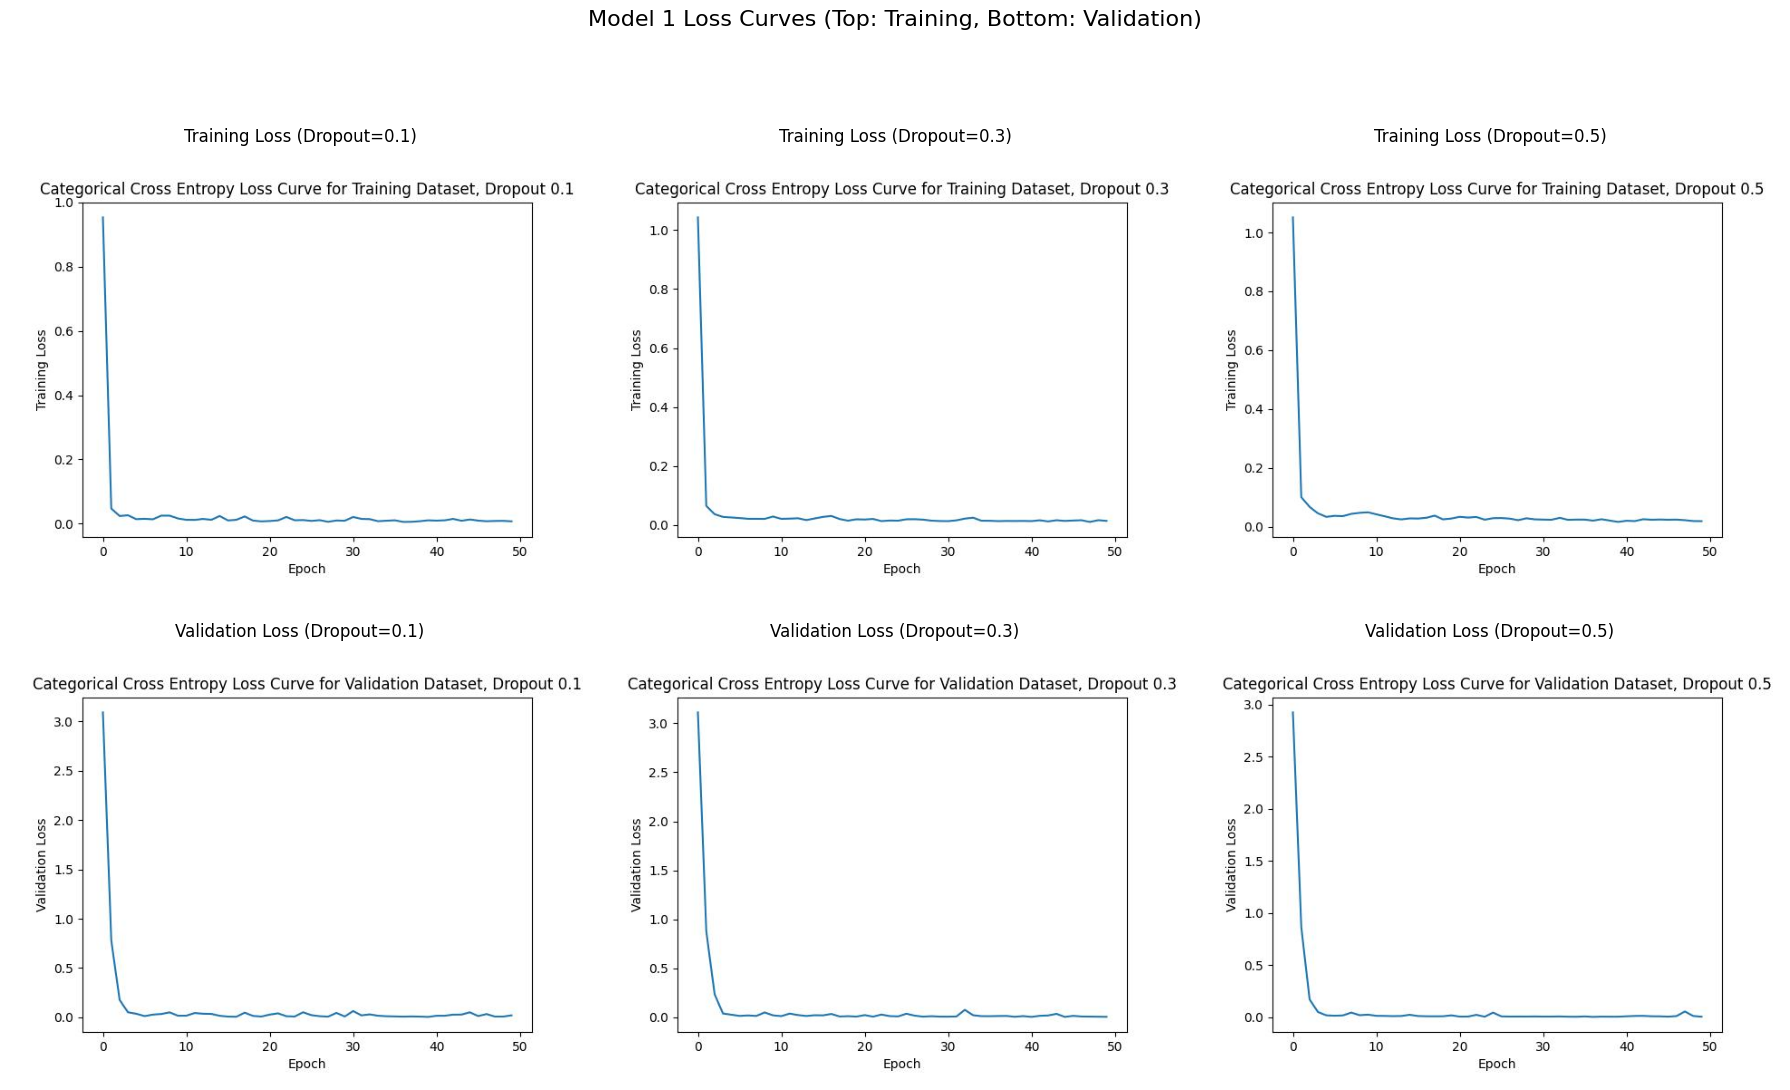

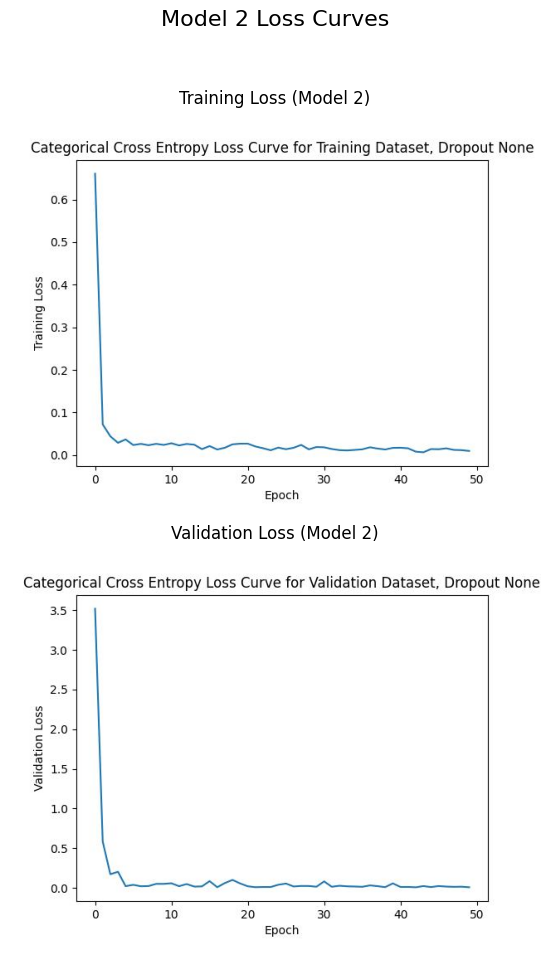

In [15]:
# Plot all loss curves together
# Display the Model 1 loss curve images (Training & Validation) in a 2x3 grid
# Display Model 2 loss curve images (Training & Validation) stacked 2x1

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define subfolder and filenames
# If local:
# plot_folder = "HW_02_CNN/plots"
# If running in Colab online:
plot_folder = "/content/Plot JPGs"

# Debug: List files to ensure we have the right names
if os.path.exists(plot_folder):
    print(f"Files in {plot_folder}: {os.listdir(plot_folder)}")
else:
    print(f"Folder {plot_folder} not found!")

# --- Model 1 ---
# Rows: Training, Validation
# Cols: Dropout 0.1, 0.3, 0.5

dropouts = [0.1, 0.3, 0.5]
datasets = ["Training", "Validation"]

# Increased figure height to 12 to allow more space
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Model 1 Loss Curves (Top: Training, Bottom: Validation)", fontsize=16)

for row_idx, dataset in enumerate(datasets):
    for col_idx, dropout in enumerate(dropouts):
        # Filename format from plot_loss: LossCurve_{dataset}_Dataset_{dropout}_Dropout.jpg
        fname = f"LossCurve_{dataset}_Dataset_{dropout}_Dropout.jpg"
        img_path = os.path.join(plot_folder, fname)
        ax = axs[row_idx, col_idx]

        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f"{dataset} Loss (Dropout={dropout})", fontsize=12)
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, f"File not found:\n{fname}", ha='center', va='center')
            ax.axis('off')

# Added h_pad=3.0 to increase vertical spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=3.0)
plt.show()

# --- Model 2 ---
# Stacked: Training on top, Validation on bottom
# In run_experiment(2, ...), dropout defaults to None, so filename has 'None'
model2_dropout = "None"

fig, axs = plt.subplots(2, 1, figsize=(8, 10))
fig.suptitle("Model 2 Loss Curves", fontsize=16)

for row_idx, dataset in enumerate(datasets):
    fname = f"LossCurve_{dataset}_Dataset_{model2_dropout}_Dropout.jpg"
    img_path = os.path.join(plot_folder, fname)
    ax = axs[row_idx]

    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"{dataset} Loss (Model 2)", fontsize=12)
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, f"File not found:\n{fname}", ha='center', va='center')
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Discussion:**

**Role of dropout and impact on performance**

- Low dropout = 0.1: Regularization is mild, with the highest training accuracy (≈99.85%) but the lowest test accuracy (≈95.92%).
- Medium dropout = 0.3: Training accuracy slightly decreased in return for slightly improved validation and test accuracy.  
- High dropout = 0.5: Training accuracy is even lower (≈99.66%) than dropout = 0.1 because many units are dropped each step, but validation and test accuracy in these runs were best (≈99.95% validation, ≈96.51% test). This indicates that for this dataset and architecture, the 2-layer ConvNet benefited from stronger regularization to generalize better to the test set.

Overall, increasing dropout in Model 1 (0.1 → 0.3 → 0.5) improved validation and test accuracy, showing that dropout effectively limited overfitting and improved generalization for this classification task.

**Role of convolutional layers and impact on performance**

Adding a third convolutional layer in Model 2 increases the network's capacity and depth of the feature hierarchy. In this set of experiments, Model 2 (3 conv layers, 64→128→256, dropout 0.3) achieved the best test accuracy of all 4 model iterations ran (≈96.79%) and the lowest final test loss (≈1.69) among all configurations. The extra conv layer and larger classifier (512 units) allowed the model to learn a richer hierarchy of features and to generalize better than the 2-layer Model 1 variants.

Bonus (+1): A skip connection in a neural network is a connection that skips one or more layers and connects to a later layer. Residual Networks (ResNets) have popularized the use of skip connections to address the vanishing gradient problem, and hence enabling the training of deeper networks. Your task for this bonus part is to integrate such a skip connection, any types of skip connections are acceptable. For instance, linking the output of the first layer convolutional directly to the input of the last convolutional layer in your model architecture. Based on your results, analyze and discuss any improvements or effects this change has on the model's performance